In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import math
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers


In [2]:
# 数据处理
# 离群值处理
def outlier_func(s):
    q01 = s.quantile(q=0.01)
    q99 = s.quantile(q=0.99)

    s = np.minimum(s,q99)
    s = np.maximum(s,q01)
    return s

# 回归函数参数
def regre_params(x, formula):
    return smf.ols(formula, data=x).fit().params

# 回归函数残差
def regre_resid(x, formula):
    return smf.ols(formula, data=x).fit().resid

# 获取对应时间节点的股票dataframe
def stock_df(proj_dataframe, t=120):
    # get the 120 months dates
    date_list = proj_dataframe['DATE'].unique()[t-120:t].tolist()
    
    # get the list of stock in the target date
    date = date_list[-1]
    target_stock_list = proj_dataframe.loc[proj_dataframe['DATE'] == date]['PERMNO'].to_list()
    # construct the regression dataframe according to date and stock list
    reg_project = proj_dataframe.loc[proj_dataframe['DATE'].isin(date_list)]
    # eliminate stocks that have less than 100 month data
    reg_project = reg_project.loc[reg_project['PERMNO'].isin(target_stock_list)].groupby('PERMNO').filter(lambda x : len(x) > 100)
    reg_project = reg_project.set_index('PERMNO')    
    
    return reg_project

In [3]:
# 协方差和收益率矩阵的计算
# 计算样本周期内收益率矩阵和协方差矩阵
def char_variance_matrix(reg_project_dataframe):
    '''
    reg_project_dataframe: 存入的前一百二十个月股票特征数据
    '''
    reg_params = reg_project_dataframe.groupby('DATE').apply(regre_params, 'exret ~ mkt_beta + logme + logbeme + r_2_12 + gp + invest_asset - 1')
    params_var = reg_params.cov(ddof=6)
    
    current_date = reg_project_dataframe.DATE.tolist()[-1]
    reg_project_dataframe = reg_project_dataframe.loc[reg_project_dataframe['DATE'] == current_date][['mkt_beta', 'logme', 'logbeme', 'r_2_12', 'gp', 'invest_asset']]

    reg_var = np.dot(reg_project_dataframe, np.dot(params_var, reg_project_dataframe.T))
    
    return reg_var


def residual_matrix(reg_project_dataframe):
    
    reg_resid = reg_project_dataframe.groupby('DATE').apply(regre_resid, 'exret ~ mkt_beta + logme + logbeme + r_2_12 + gp + invest_asset - 1')
    reg_resid_df = reg_resid.to_frame(name='resid').reset_index()
    reg_resid_df = reg_resid_df.set_index(['DATE','PERMNO'])['resid'].unstack().rename_axis(columns=None).reset_index()
    # 残差的方差
    resid_var = pd.Series(reg_resid_df.set_index('DATE').var())
    resid_var_df = pd.DataFrame(0, index=resid_var.index, columns=resid_var.index, dtype=resid_var.dtype)

    # 对角线填入
    np.fill_diagonal(resid_var_df.values, resid_var)

    
    return resid_var_df

# 预期股票收益率协方差矩阵为 因子暴露的转置与因子方差点乘因子暴露 加上残差方差矩阵
def covariance_matrix(reg_project_dataframe):
    
    a = char_variance_matrix(reg_project_dataframe)
    b = residual_matrix(reg_project_dataframe)
    
    return a+b

# 预期收益率向量为股票因子暴露与相应因子预测收益率相乘之和。
def return_col(reg_project_dataframe):
    
    reg_params = reg_project_dataframe.groupby('DATE').apply(regre_params, 'exret ~ mkt_beta + logme + logbeme + r_2_12 + gp + invest_asset - 1')
    estimate_params = reg_params.mean()
    
    current_date = reg_project_dataframe.DATE.tolist()[-1]
    reg_project_dataframe = reg_project_dataframe.loc[reg_project_dataframe['DATE'] == current_date][['mkt_beta', 'logme', 'logbeme', 'r_2_12', 'gp', 'invest_asset']]
    ret_col = reg_project_dataframe.dot(estimate_params)
    
    return ret_col

In [4]:
# 最小方差组合的计算
def minimal_variance_portfolio(cov_matrix, date):
    
    e = np.ones(len(cov_matrix))
    e = pd.DataFrame(e,index=cov_matrix.index)

    cov_matrix_inv = pd.DataFrame(np.linalg.inv(cov_matrix.values), cov_matrix.columns, cov_matrix.index)

    weights = np.dot(cov_matrix_inv,e)/np.dot(np.transpose(e), np.dot(cov_matrix_inv, e))
    weights = pd.DataFrame(weights, index=cov_matrix.index, columns=[date], dtype='double')
    
    return weights

In [5]:
# BARRA Mean-Var Portfolio的计算
def barra_mean_variance_portfolio(cov_matrix, return_col, reg_project_opt, date):
    '''
    使用cvxopt求解二次规划, 计算最优权重
    '''
    P = (3/2)*matrix(np.array(cov_matrix))
    q = -matrix(np.array(ret_col_opt.T))
    
    current_date = int(reg_project_opt['DATE'][-1:].values)
    beta = reg_project_opt[(reg_project_opt.index.isin(ret_col_opt.index)) & (reg_project_opt['DATE'] == current_date)]['mkt_beta']
    log_ME = reg_project_opt[(reg_project_opt.index.isin(ret_col_opt.index)) & (reg_project_opt['DATE'] == current_date)]['logme']

    A = matrix(np.array([[1 for _ in range(len(cov_matrix))] , beta, log_ME]))
    b = matrix([0,0,0], tc='d')
    G = matrix(np.r_[np.identity(len(cov_matrix)), -np.identity(len(cov_matrix))])
    h = matrix(np.array([0.01 for _ in range(np.array(G).shape[0])]))
    
    sol = solvers.qp(P, q, G, h, A, b)
    weights = pd.DataFrame(np.array(sol['x']), index=ret_col_opt.index, columns=[date], dtype='double')
    
    return weights
    

In [11]:
# 读取数据
project = pd.read_csv(r'C:\Users\98749\vscode\python\QA_FinalProject\finalproj.csv')
# project['DATE'] = pd.to_datetime(project['DATE'].astype('string'))
project = project.dropna()
riskfactor = pd.read_csv(r'C:\Users\98749\vscode\python\QA_FinalProject\riskfactor.csv')
# riskfactor['date'] = pd.to_datetime(riskfactor['date'].astype('string'))
# 公司特征变量名称
firm_char = ['logme', 'logbeme', 'r_2_12', 'gp', 'invest_asset']


In [14]:
# 复制数据进行处理，不改变原数据
final_proj = project.copy()
# Data Preprocessing, handling outlier and standardized
final_proj = final_proj.groupby('DATE').apply(lambda x : x.apply(lambda y : outlier_func(y) if y.name in firm_char else y))
final_proj = final_proj.groupby('DATE').apply(lambda x : x.apply(lambda y: ((y - y.mean()) / y.std()) if y.name in firm_char else y))

In [198]:
# 获取t=120的前120个月股票数据
reg_project = stock_df(final_proj, t=120)
# 计算协方差矩阵，收益率向量，下一期的最小方差组合权重
covariance_matirx = covariance_matrix(reg_project)
ret_col = return_col(reg_project)
weights = minimal_variance_portfolio(covariance_matirx, date=reg_project.DATE.tolist()[-1])

In [16]:
weights_df = pd.DataFrame()
for t in range(120, len(riskfactor)):
    reg_project = stock_df(final_proj, t=t)
    
    covariance_matirx = covariance_matrix(reg_project)
    ret_col = return_col(reg_project)
    weights = minimal_variance_portfolio(covariance_matirx, date=riskfactor.date.tolist()[t])

    weights_df = pd.concat([weights_df, weights.T])

In [6]:
# 根据权重计算收益率
def cal_daily_return(weights_df, proj_data, date_list, rf):
    ret_data = pd.DataFrame(columns=['monthly_exret'])
    
    for day in date_list:
        day_weight = weights_df.loc[day].dropna()
        day_weight.index = day_weight.index.astype('int')
        
        day_ret = final_proj[(final_proj['DATE'] == day) & (final_proj['PERMNO'].isin(day_weight.index.astype('int').tolist()))][['PERMNO', 'exret']]
        day_ret = day_ret.set_index('PERMNO')
        
        day_weight = day_weight[day_ret.index.tolist()]
        ret = day_ret.T.dot(day_weight)
        ret.index = [day]
        
        df = pd.DataFrame(ret, columns=['monthly_exret'])
        ret_data = pd.concat([ret_data, df])
    
    ret_data = ret_data.join(rf)
    ret_data['monthly_return'] = ret_data['monthly_exret'] + ret_data['RF']
        
    return ret_data

In [7]:
# 评价指标
def ret_performance(ret_data):
    '''
    annualized_ret: 年化收益, %
    annualized_exret: 年华超额收益, %
    annualized_std: 年华波动率, %
    sharpe_ratio: 夏普比率
    maximum_drawdown: 最大回撤, %
    recover_period: 最大 回撤回复周期, month
    '''
    
    ret_data.index = ret_data.index.astype('str')
    
    annualized_ret =  ret_data['monthly_return'].mean() * 12
    annualized_exret = ret_data['monthly_exret'].mean() * 12
    annualized_std = ret_data['monthly_exret'].std() * math.sqrt(12)
    sharpe_ratio = annualized_exret/annualized_std
    
    ret_data['cumret'] = (ret_data['monthly_return'] + 1).cumprod()
    ret_data['drawdown'] = (ret_data['cumret'].cummax() - ret_data['cumret']) / ret_data['cumret'].cummax()
    maximum_drawdown = ret_data['drawdown'].max()
    recover_period = ret_data['cumret'].cummax().value_counts().max()
    
    evaluation = {'annualized_ret' : annualized_ret, 'annualized_exret' : annualized_exret, 'annualized_std': annualized_std, 'sharpe_ratio': sharpe_ratio, 'maximum_drawdown': maximum_drawdown, 'recover_period' : recover_period}
    result = {'evaluation': evaluation, 'ret_data' : ret_data}

    return result
    

In [8]:
# 根据月收益率数据绘制收益率曲线
def plot_ret(ret_data):
    
    ret_data.index = ret_data.index.astype('str')
    
    ret_data['cumret'] = (ret_data['monthly_return'] + 1).cumprod()
    ret_data['cumret'].plot(label='month return curve',figsize=(20,10), grid=True)
    
    plt.legend()
    plt.show()

In [18]:
weights_df = pd.read_csv('./result/minimal_variance_weight.csv', index_col=0)
weights_df

,10006,10014,10102,10137,10145,10153,10161,10225,10233,10241,...,89406,89413,89424,89425,89443,89447,89449,89452,89453,89471
19730731,-0.001637,0.004923,-0.001215,0.001040,-0.007389,-0.000292,-0.000934,0.018788,-0.001128,0.005412,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19730831,-0.001998,0.004925,-0.002334,-0.001035,-0.009232,-0.001480,0.001024,0.016668,-0.001627,0.004110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19730928,-0.002440,0.003969,-0.000744,-0.001246,-0.012242,-0.002219,-0.000724,0.013467,-0.000710,0.007000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19731031,-0.001637,0.003747,-0.002241,0.003368,-0.011026,-0.001564,-0.003214,0.009135,-0.001355,0.006012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19731130,-0.000055,0.003599,-0.002363,0.001208,-0.009735,-0.002822,-0.003147,0.009423,-0.002311,0.005980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20140930,NaN,NaN,NaN,NaN,-0.001801,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20141031,NaN,NaN,NaN,NaN,-0.001572,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20141128,NaN,NaN,NaN,NaN,-0.001841,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20141231,NaN,NaN,NaN,NaN,-0.001807,NaN,NaN,NaN,NaN,NaN,...,0.000021,-0.000187,0.000109,0.000327,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
date_list = riskfactor.date.tolist()
rf = riskfactor.set_index('date')['RF']

In [20]:
mv_daily_return = cal_daily_return(weights_df, final_proj, date_list[120:], rf)
mv_daily_return

,monthly_exret,RF,monthly_return
19730731,-0.043389,0.0064,-0.036989
19730831,-0.042246,0.0070,-0.035246
19730928,0.034946,0.0068,0.041746
19731031,-0.053519,0.0065,-0.047019
19731130,-0.071883,0.0056,-0.066283
...,...,...,...
20140930,-0.001062,0.0000,-0.001062
20141031,0.072545,0.0000,0.072545
20141128,0.027505,0.0000,0.027505
20141231,0.029619,0.0000,0.029619


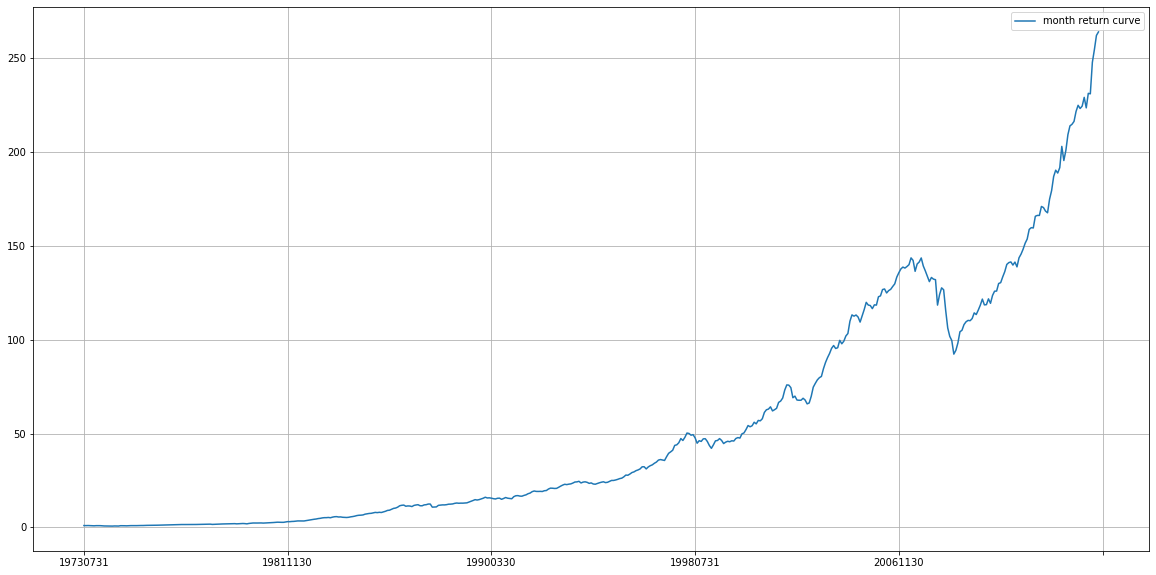

In [21]:
plot_ret(mv_daily_return)

In [37]:
mv_performance = ret_performance(mv_daily_return)['evaluation']
mv_performance

{'annualized_ret': 0.1405652191753496,
 'annualized_exret': 0.09121612097895689,
 'annualized_std': 0.10776409035963813,
 'sharpe_ratio': 0.8464426384943615,
 'maximum_drawdown': 0.3571259365769744,
 'recover_period': 53}

In [23]:
barra_weights_df = pd.read_csv('./result/barra_optimal_weight.csv', index_col=0)
barra_weights_df

,10006,10014,10102,10137,10145,10153,10161,10225,10233,10241,...,89406,89413,89424,89425,89443,89447,89449,89452,89453,89471
19730731,0.01,-0.01,-0.01,-0.01,0.01,-0.01,0.01,-0.010000,-0.010000,0.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19730831,0.01,-0.01,-0.01,0.01,0.01,-0.01,0.01,-0.010000,-0.010000,0.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19730928,0.01,-0.01,-0.01,0.01,0.01,0.01,0.01,-0.010000,-0.010000,0.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19731031,0.01,-0.01,-0.01,-0.01,0.01,-0.01,0.01,-0.009999,-0.010000,0.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19731130,0.01,-0.01,-0.01,0.01,0.01,0.01,0.01,-0.010000,0.006385,0.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20140930,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20141031,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20141128,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20141231,NaN,NaN,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,...,0.01,0.01,-0.007785,-0.01,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
barra_daily_return = cal_daily_return(barra_weights_df, final_proj, date_list[120:], rf)
barra_daily_return

,monthly_exret,RF,monthly_return
19730731,-0.030038,0.0064,-0.023638
19730831,0.032984,0.0070,0.039984
19730928,-0.014203,0.0068,-0.007403
19731031,0.097362,0.0065,0.103862
19731130,0.059070,0.0056,0.064670
...,...,...,...
20140930,0.032286,0.0000,0.032286
20141031,-0.060813,0.0000,-0.060813
20141128,0.111833,0.0000,0.111833
20141231,0.038486,0.0000,0.038486


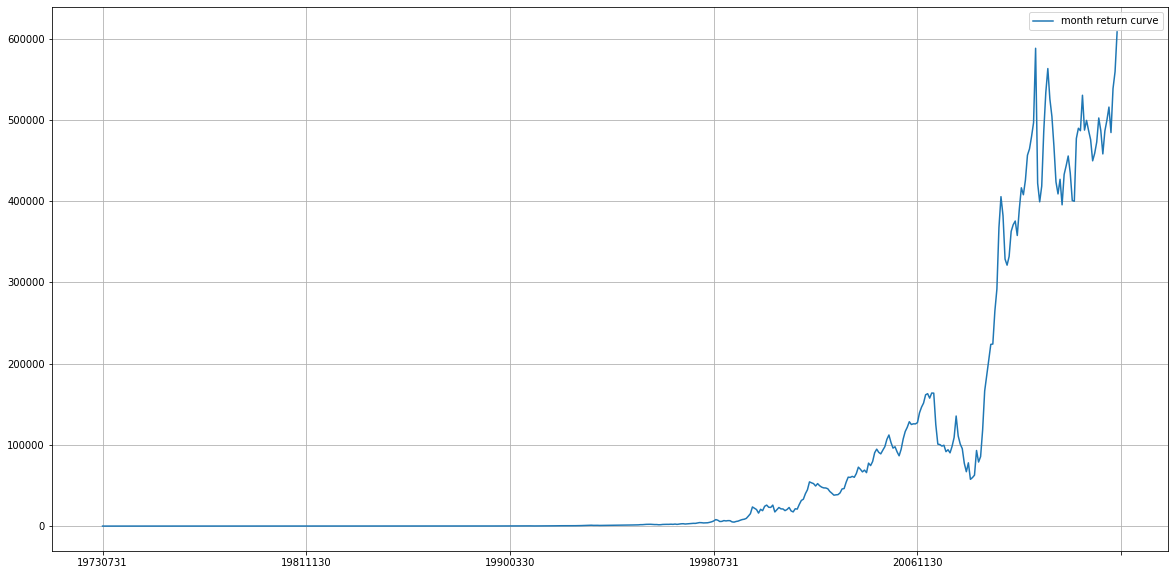

In [35]:
plot_ret(barra_daily_return)

In [36]:
barra_performance = ret_performance(barra_daily_return)['evaluation']
barra_performance

{'annualized_ret': 0.3855528026110061,
 'annualized_exret': 0.3362037044146138,
 'annualized_std': 0.35402169975023656,
 'sharpe_ratio': 0.9496697650223321,
 'maximum_drawdown': 0.6486965392897123,
 'recover_period': 40}